# Backtesting strategies

Documentation for bt library:
https://pmorissette.github.io/bt/examples.html

In [1]:
import bt
import talib

# Data Extraction

In [2]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

### Extract data from Binance exchange

In [32]:
def read_from_exchange_n(symbol: str, timeframe:str, n=1000) -> pd.DataFrame:
    '''Reads the lasts n candlesticks for different timeframes, 
    Parameters
    -----------
    symbol: "BTC"
    timeframes intervals: "1d"
    Kline/Candlestick chart intervals: m -> minutes; h -> hours; d -> days; w -> weeks; M -> months
    1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M

    n : INT number of past observations
    '''
    url_base = "https://api.binance.com/"
    url_endpoint = "api/v3/klines"
    binance_candlesticks = requests.get(url_base + url_endpoint + "?symbol={}USDT&interval={}&limit={}".format(symbol, timeframe, n))
    candlestick_info = binance_candlesticks.json()
    
    #Transform into Pandas dataframe to easy manipulation
    df = pd.DataFrame(candlestick_info)
    
    #changing column names
    df.columns = ["Opentime", "Open", "High", "Low", "Close", "Volume", "CloseTime", "QuoteAssetVolume", "NumberOfTrades", "TakerBuyBaseAssetVolume", "TakerBuyQuoteAssetVolume", "Ignore"]
    
    #changing types, objects to float, and unixtimestamp to timestamp
    df['Opentime'] = pd.to_datetime(df['Opentime'], unit='ms', dayfirst=True, origin= "unix")
    df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='ms', dayfirst=True, origin= "unix")
    df = df.astype({'Open':'float', 'High': 'float', 'Low': 'float', 'Close': 'float', 'Volume': 'float', 'QuoteAssetVolume': 'float64', 'TakerBuyBaseAssetVolume': 'float64', 'TakerBuyQuoteAssetVolume':'float64'})
    
    #setting date as index
    df = df.set_index("Opentime")

    return df

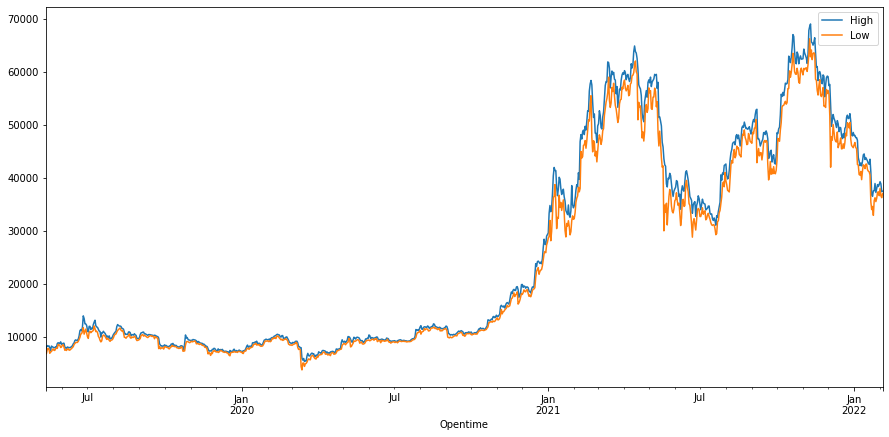

In [33]:
btc_binance = read_from_exchange_n('BTC', '1d', n=1000)
btc_binance[['High', 'Low']].plot(figsize=(15, 7))
plt.show()

In [34]:
btc_binance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2019-05-12 to 2022-02-04
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Open                      1000 non-null   float64       
 1   High                      1000 non-null   float64       
 2   Low                       1000 non-null   float64       
 3   Close                     1000 non-null   float64       
 4   Volume                    1000 non-null   float64       
 5   CloseTime                 1000 non-null   datetime64[ns]
 6   QuoteAssetVolume          1000 non-null   float64       
 7   NumberOfTrades            1000 non-null   int64         
 8   TakerBuyBaseAssetVolume   1000 non-null   float64       
 9   TakerBuyQuoteAssetVolume  1000 non-null   float64       
 10  Ignore                    1000 non-null   object        
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usa

In [35]:
btc_binance = btc_binance[['Open', 'High', 'Low', 'Close', 'Volume']]
btc_binance.head()

,Open,High,Low,Close,Volume
Opentime,,,,,
2019-05-12,7076.24,7521.78,6750.00,6967.31,86948.975339
2019-05-13,6968.24,8100.00,6870.00,7790.71,85804.735333
2019-05-14,7795.62,8366.00,7599.56,7947.56,76583.722603
2019-05-15,7945.26,8249.00,7850.00,8169.87,37884.327211
2019-05-16,8169.08,8320.00,7705.00,7866.59,69630.513996


### Extracting historical data from yahoo

In [36]:
from pandas_datareader import data
import datetime

In [42]:
#get historical data
btc_yahoo = data.DataReader("BTC-USD", 
                       start='2014-09-17', #oldest day is 2014-09-17
                       end= datetime.date.today() - datetime.timedelta(days= 1000), 
                       data_source='yahoo')

In [43]:
btc_yahoo = btc_yahoo[['High', 'Low', 'Open', 'Close', 'Volume']]
btc_yahoo = btc_yahoo.astype({'Volume':'float'})

btc_yahoo.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2019-05-07,5988.178223,5741.395996,5745.599121,5829.501465,1.802641e+10
2019-05-08,5989.980957,5794.715820,5849.481445,5982.457520,1.532061e+10
2019-05-09,6183.039062,5982.316406,5982.316406,6174.528809,1.678465e+10
2019-05-10,6434.617676,6161.519043,6175.822754,6378.849121,1.941988e+10
2019-05-11,7333.002930,6375.698730,6379.666992,7204.771484,2.886756e+10


In [44]:
btc_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1698 entries, 2014-09-17 to 2019-05-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    1698 non-null   float64
 1   Low     1698 non-null   float64
 2   Open    1698 non-null   float64
 3   Close   1698 non-null   float64
 4   Volume  1698 non-null   float64
dtypes: float64(5)
memory usage: 79.6 KB


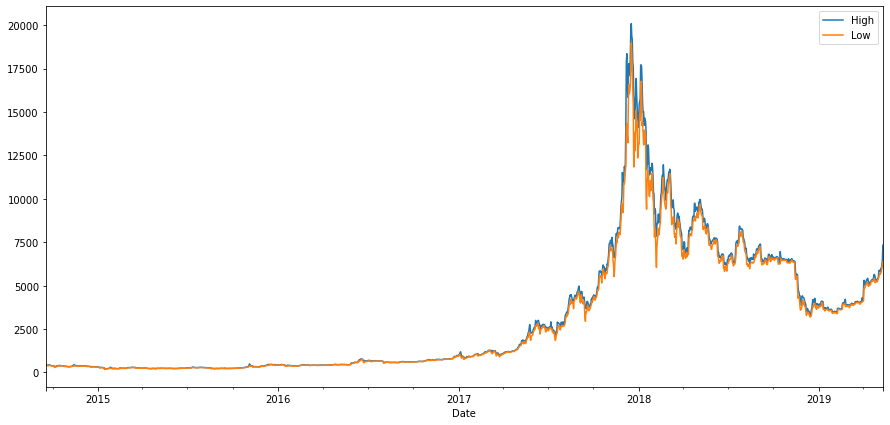

In [130]:
btc_yahoo[['High', 'Low']].plot(figsize=(15, 7))
plt.show()

# Historical Data merged datasets

## Concat dataframes btc_binance and btc_yahoo

In [45]:
#This works fine, it merges indexes and equivalent columns
#the problem is that it overlaps indexes if the dates are not precise

# Concat merged
concat_df = pd.concat([btc_yahoo, btc_binance], join='outer')
concat_df

,High,Low,Open,Close,Volume
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07
...,...,...,...,...,...
2022-01-31,38744.000000,36632.610000,37881.750000,38466.900000,3.685525e+04
2022-02-01,39265.200000,38000.000000,38466.900000,38694.590000,3.457445e+04
2022-02-02,38855.920000,36586.950000,38694.590000,36896.360000,3.579468e+04
2022-02-03,37387.000000,36250.000000,36896.370000,37311.610000,3.208111e+04


In [141]:
#Check for index overlaps, since indexes are not merged with concat :(
index_overlap_test = concat_df.loc[btc_yahoo.index[-3].date() : btc_binance.index[2].date(), :]
index_overlap_test

,High,Low,Open,Close,Volume
2019-05-09,6183.039062,5982.316406,5982.316406,6174.528809,1.678465e+10
2019-05-10,6434.617676,6161.519043,6175.822754,6378.849121,1.941988e+10
2019-05-11,7333.002930,6375.698730,6379.666992,7204.771484,2.886756e+10
2019-05-12,7521.780000,6750.000000,7076.240000,6967.310000,8.694898e+04
2019-05-13,8100.000000,6870.000000,6968.240000,7790.710000,8.580474e+04
2019-05-14,8366.000000,7599.560000,7795.620000,7947.560000,7.658372e+04


## Concat on axis 0

In [145]:
concat_df_0 = pd.concat([btc_yahoo, btc_binance], axis=0)
concat_df_0

,High,Low,Open,Close,Volume
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07
...,...,...,...,...,...
2022-01-31,38744.000000,36632.610000,37881.750000,38466.900000,3.685525e+04
2022-02-01,39265.200000,38000.000000,38466.900000,38694.590000,3.457445e+04
2022-02-02,38855.920000,36586.950000,38694.590000,36896.360000,3.579468e+04
2022-02-03,37387.000000,36250.000000,36896.370000,37311.610000,3.208111e+04


In [146]:
index_overlap2 = concat_df_0.loc[btc_yahoo.index[-3].date() : btc_binance.index[2].date(), :]
index_overlap2

,High,Low,Open,Close,Volume
2019-05-09,6183.039062,5982.316406,5982.316406,6174.528809,1.678465e+10
2019-05-10,6434.617676,6161.519043,6175.822754,6378.849121,1.941988e+10
2019-05-11,7333.002930,6375.698730,6379.666992,7204.771484,2.886756e+10
2019-05-12,7521.780000,6750.000000,7076.240000,6967.310000,8.694898e+04
2019-05-13,8100.000000,6870.000000,6968.240000,7790.710000,8.580474e+04
2019-05-14,8366.000000,7599.560000,7795.620000,7947.560000,7.658372e+04


### Merge on indexes as columns

In [150]:
#merged Dataset on indexes
btc_merged_daily = btc_yahoo.merge(btc_binance, how="outer", left_on=[btc_yahoo.index, "High", "Low", "Open", "Close", "Volume"], right_on= [btc_binance.index, "High", "Low", "Open", "Close", "Volume"])
#transforming generated index column to index column
btc_merged_daily = btc_merged_daily.set_index('key_0')
#changing index name
btc_merged_daily.index.names = ['Datetime']
btc_merged_daily

,High,Low,Open,Close,Volume
Datetime,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07
...,...,...,...,...,...
2022-01-31,38744.000000,36632.610000,37881.750000,38466.900000,3.685525e+04
2022-02-01,39265.200000,38000.000000,38466.900000,38694.590000,3.457445e+04
2022-02-02,38855.920000,36586.950000,38694.590000,36896.360000,3.579468e+04


In [151]:
#check for index overlap
index_overlap3 = btc_merged_daily.loc[btc_yahoo.index[-3].date() : btc_binance.index[2].date(), :]
index_overlap3

,High,Low,Open,Close,Volume
Datetime,,,,,
2019-05-09,6183.039062,5982.316406,5982.316406,6174.528809,1.678465e+10
2019-05-10,6434.617676,6161.519043,6175.822754,6378.849121,1.941988e+10
2019-05-11,7333.002930,6375.698730,6379.666992,7204.771484,2.886756e+10
2019-05-12,7521.780000,6750.000000,7076.240000,6967.310000,8.694898e+04
2019-05-13,8100.000000,6870.000000,6968.240000,7790.710000,8.580474e+04
2019-05-14,8366.000000,7599.560000,7795.620000,7947.560000,7.658372e+04


## Merged Dataset daily

In [152]:
btc_merged_daily

,High,Low,Open,Close,Volume
Datetime,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07
...,...,...,...,...,...
2022-01-31,38744.000000,36632.610000,37881.750000,38466.900000,3.685525e+04
2022-02-01,39265.200000,38000.000000,38466.900000,38694.590000,3.457445e+04
2022-02-02,38855.920000,36586.950000,38694.590000,36896.360000,3.579468e+04


<AxesSubplot:xlabel='Datetime'>

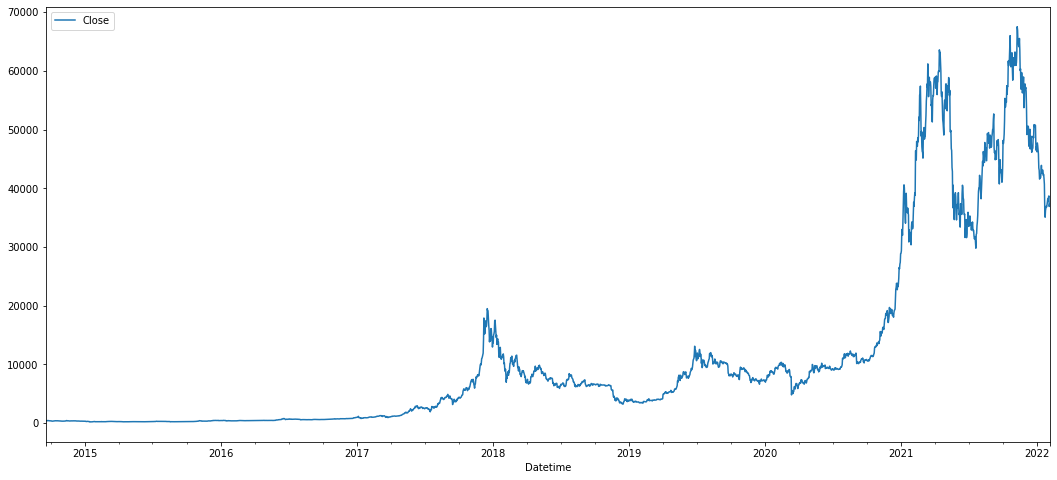

In [153]:
#Plot to see entire close prices

btc_merged_daily[['Close']].plot(figsize=(18, 8))

## Weekly dataset

### Weekly data from binance

In [154]:
btc_binance_weekly = read_from_exchange_n('BTC', timeframe='1w')
btc_binance_weekly = btc_binance_weekly[['Open', 'High', 'Low','Close', 'Volume' ]]
btc_binance_weekly

,Open,High,Low,Close,Volume
Opentime,,,,,
2017-08-14,4261.48,4485.39,3850.00,4086.29,2843.431426
2017-08-21,4069.13,4453.91,3400.00,4310.01,4599.396629
2017-08-28,4310.01,4939.19,4124.54,4509.08,4753.843376
2017-09-04,4505.00,4788.59,3603.00,4130.37,6382.787745
2017-09-11,4153.62,4394.59,2817.00,3699.99,8106.705127
...,...,...,...,...,...
2022-01-03,47286.18,47570.00,40501.00,41864.62,264331.615870
2022-01-10,41864.62,44500.00,39650.00,43071.66,232059.069690
2022-01-17,43071.66,43505.00,34008.00,36244.55,354513.984320


### Option 1: Resampling daily dataset from days to weeks

In [160]:
#Generating a weekly dataset from daily dataset
btc_merged_weekly_test = btc_merged.asfreq(freq="W", method='backfill', normalize= True)
btc_merged_weekly_test

#Note: * There is a resample from daily to weekly however it is shifted by -1 day

,High,Low,Open,Close,Volume
Datetime,,,,,
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07
2014-09-28,401.016998,374.332001,399.471008,377.181000,2.361330e+07
2014-10-05,341.800995,289.295990,328.915985,320.510010,8.330810e+07
2014-10-12,379.433014,356.144012,362.605988,378.549011,1.755280e+07
2014-10-19,393.938995,386.457001,391.253998,389.545990,5.914570e+06
...,...,...,...,...,...
2022-01-02,47990.000000,46654.000000,47722.660000,47286.180000,1.834046e+04
2022-01-09,42786.700000,41200.020000,41679.740000,41864.620000,2.272439e+04
2022-01-16,43475.000000,42581.790000,43084.290000,43071.660000,2.060235e+04


### Obtaining weekly data directly from yahoo finance

In [158]:
import pandas_datareader as pdr

In [159]:
#weekly info
btc_yahoo_weekly = pdr.yahoo.daily.YahooDailyReader('BTC-USD', start='2014-09-10', end='2017-08-10', interval= 'w').read() # datetime.date.today()- datetime.timedelta(days= 1001)
btc_yahoo_weekly = btc_yahoo_weekly.astype({'Volume':'float'})

btc_yahoo_weekly

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-15,468.174011,384.532013,465.864014,398.821014,1.569034e+08,398.821014
2014-09-22,441.557007,374.332001,399.100006,377.181000,1.867726e+08,377.181000
2014-09-29,391.378998,289.295990,376.928009,320.510010,2.766579e+08,320.510010
2014-10-06,382.726013,302.559998,320.389008,378.549011,3.411528e+08,378.549011
2014-10-13,411.697998,368.897003,377.920990,389.545990,1.569021e+08,389.545990
...,...,...,...,...,...,...
2017-07-10,2537.159912,1843.030029,2525.250000,1929.819946,7.453121e+09,1929.819946
2017-07-17,2900.699951,1932.619995,1932.619995,2730.399902,9.947990e+09,2730.399902
2017-07-24,2897.449951,2450.800049,2732.699951,2757.179932,6.942861e+09,2757.179932


## Merged weekly dataset

In [162]:
btc_yahoo_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 152 entries, 2014-09-15 to 2017-08-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       152 non-null    float64
 1   Low        152 non-null    float64
 2   Open       152 non-null    float64
 3   Close      152 non-null    float64
 4   Volume     152 non-null    float64
 5   Adj Close  152 non-null    float64
dtypes: float64(6)
memory usage: 8.3 KB


In [163]:
btc_binance_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2017-08-14 to 2022-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    234 non-null    float64
 1   High    234 non-null    float64
 2   Low     234 non-null    float64
 3   Close   234 non-null    float64
 4   Volume  234 non-null    float64
dtypes: float64(5)
memory usage: 11.0 KB


In [164]:
#merged Dataset
btc_merged_weekly = btc_yahoo_weekly.merge(btc_binance_weekly, how="outer", left_on=[btc_yahoo_weekly.index, "High", "Low", "Open", "Close", "Volume"], right_on= [btc_binance_weekly.index, "High", "Low", "Open", "Close", "Volume"])
btc_merged_weekly = btc_merged_weekly.set_index('key_0')
#changing index name
btc_merged_weekly.index.names = ['Datetime']
btc_merged_weekly

,High,Low,Open,Close,Volume,Adj Close
Datetime,,,,,,
2014-09-15,468.174011,384.532013,465.864014,398.821014,1.569034e+08,398.821014
2014-09-22,441.557007,374.332001,399.100006,377.181000,1.867726e+08,377.181000
2014-09-29,391.378998,289.295990,376.928009,320.510010,2.766579e+08,320.510010
2014-10-06,382.726013,302.559998,320.389008,378.549011,3.411528e+08,378.549011
2014-10-13,411.697998,368.897003,377.920990,389.545990,1.569021e+08,389.545990
...,...,...,...,...,...,...
2022-01-03,47570.000000,40501.000000,47286.180000,41864.620000,2.643316e+05,NaN
2022-01-10,44500.000000,39650.000000,41864.620000,43071.660000,2.320591e+05,NaN
2022-01-17,43505.000000,34008.000000,43071.660000,36244.550000,3.545140e+05,NaN


In [165]:
#check for index overlap
index_overlap4 = btc_merged_weekly.loc[btc_yahoo_weekly.index[-3].date() : btc_binance_weekly.index[2].date(), :]

index_overlap4

,High,Low,Open,Close,Volume,Adj Close
Datetime,,,,,,
2017-07-24,2897.449951,2450.800049,2732.699951,2757.179932,6.942861e+09,2757.179932
2017-07-31,3293.290039,2668.590088,2763.239990,3213.939941,8.137842e+09,3213.939941
2017-08-07,3679.719971,3180.889893,3212.780029,3650.620117,8.240300e+09,3650.620117
2017-08-14,4485.390000,3850.000000,4261.480000,4086.290000,2.843431e+03,NaN
2017-08-21,4453.910000,3400.000000,4069.130000,4310.010000,4.599397e+03,NaN
2017-08-28,4939.190000,4124.540000,4310.010000,4509.080000,4.753843e+03,NaN


<AxesSubplot:xlabel='Datetime'>

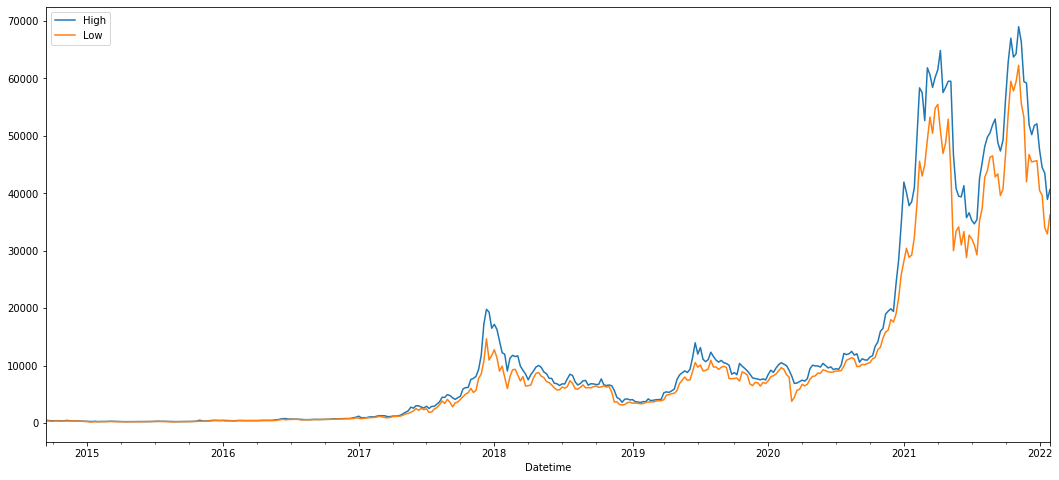

In [168]:
btc_merged_weekly[['High', 'Low']].plot(figsize=(18, 8))



## Plotly visualization of btc_merged_weekly

In [178]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure(data=[go.Candlestick(x=btc_merged_weekly.index,
                open=btc_merged_weekly['Open'],
                high=btc_merged_weekly['High'],
                low=btc_merged_weekly['Low'],
                close=btc_merged_weekly['Close'])])

fig.show()

# General Datasets with calculated indicators

### Daily dataset with indicators

In [171]:
#Calculate the indicators

#Calculate different time periods of EMAs
btc_merged_daily['EMA_20'] = talib.EMA(btc_merged_daily['Close'], timeperiod=20)
btc_merged_daily['EMA_50'] = talib.EMA(btc_merged_daily['Close'], timeperiod=50)
btc_merged_daily['EMA_100'] = talib.EMA(btc_merged_daily['Close'], timeperiod=100)
btc_merged_daily['EMA_200'] = talib.EMA(btc_merged_daily['Close'], timeperiod=200)

#Bollinger Bands
from talib import MA_Type

upper, middle, lower = talib.BBANDS(btc_merged_daily['Close'], matype=MA_Type.T3)
btc_merged_daily['BB_upper'] = upper
btc_merged_daily['BB_middle'] = middle
btc_merged_daily['BB_lower'] = lower

#RSI
btc_merged_daily['RSI'] = talib.RSI(btc_merged_daily['Close'], timeperiod=14)

#Filling NaB
btc_merged_daily.fillna(value = 0, inplace = True)

btc_merged_daily

,High,Low,Open,Close,Volume,EMA_20,EMA_50,EMA_100,EMA_200,BB_upper,BB_middle,BB_lower,RSI
Datetime,,,,,,,,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,38744.000000,36632.610000,37881.750000,38466.900000,3.685525e+04,39368.685577,43410.166975,46829.192513,47349.435517,38185.118499,37303.443619,36421.768738,40.279826
2022-02-01,39265.200000,38000.000000,38466.900000,38694.590000,3.457445e+04,39304.485998,43225.242387,46668.111275,47263.317651,38409.863513,37688.271190,36966.678867,41.624131
2022-02-02,38855.920000,36586.950000,38694.590000,36896.360000,3.579468e+04,39075.140665,42977.050921,46474.611250,47160.163844,39079.526865,37827.960777,36576.394689,34.935598


### Weekly dataset with indicators

In [175]:
#Weekly emas
btc_merged_weekly['EMA_20_w'] = talib.EMA(btc_merged_weekly['Close'], timeperiod=20)
btc_merged_weekly['EMA_50_w'] = talib.EMA(btc_merged_weekly['Close'], timeperiod=50)
btc_merged_weekly['EMA_100_w'] = talib.EMA(btc_merged_weekly['Close'], timeperiod=100)
btc_merged_weekly['EMA_200_w'] = talib.EMA(btc_merged_weekly['Close'], timeperiod=200)

#Bollinger Bands
upper, middle, lower = talib.BBANDS(btc_merged_weekly['Close'], matype=MA_Type.T3)
btc_merged_weekly['BB_upper'] = upper
btc_merged_weekly['BB_middle'] = middle
btc_merged_weekly['BB_lower'] = lower

#RSI
btc_merged_weekly['RSI'] = talib.RSI(btc_merged_weekly['Close'], timeperiod=14)

#Filling NaB
#btc_merged_weekly.fillna(value = 0, inplace = True)

btc_merged_weekly

,High,Low,Open,Close,Volume,Adj Close,EMA_20_w,EMA_50_w,EMA_200_w,BB_upper,BB_middle,BB_lower,RSI,EMA_100_w
Datetime,,,,,,,,,,,,,,
2014-09-15,468.174011,384.532013,465.864014,398.821014,1.569034e+08,398.821014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-22,441.557007,374.332001,399.100006,377.181000,1.867726e+08,377.181000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-29,391.378998,289.295990,376.928009,320.510010,2.766579e+08,320.510010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-06,382.726013,302.559998,320.389008,378.549011,3.411528e+08,378.549011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-13,411.697998,368.897003,377.920990,389.545990,1.569021e+08,389.545990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03,47570.000000,40501.000000,47286.180000,41864.620000,2.643316e+05,0.000000,50475.913697,44890.495978,24402.519024,54901.158901,48602.955493,42304.752085,41.868930,35360.979676
2022-01-10,44500.000000,39650.000000,41864.620000,43071.660000,2.320591e+05,0.000000,49770.746678,44819.169077,24588.281621,52802.928954,46441.822393,40080.715832,43.315304,35513.666415
2022-01-17,43505.000000,34008.000000,43071.660000,36244.550000,3.545140e+05,0.000000,48482.537471,44482.909505,24704.264391,53764.865024,43879.111635,33993.358246,37.614598,35528.139357


## Visualization EMA_20_daily, EMA_50_daily, EMA_200_weekly

In [179]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure(data=[go.Candlestick(x=btc_merged_daily.index,
                open=btc_merged_daily['Open'],
                high=btc_merged_daily['High'],
                low=btc_merged_daily['Low'],
                close=btc_merged_daily['Close'])])

#EMAs
fig.add_trace(go.Scatter(x=btc_merged_daily.index, y=btc_merged_daily['EMA_20'], mode='lines', name='ema20'))
fig.add_trace(go.Scatter(x=btc_merged_daily.index, y=btc_merged_daily['EMA_50'], mode='lines', name='ema50'))
fig.add_trace(go.Scatter(x=btc_merged_daily.index, y=btc_merged_daily['EMA_200'], mode='lines', name='ema200'))
fig.add_trace(go.Scatter(x=btc_merged_weekly.index, y=btc_merged_weekly['EMA_200_w'], mode='lines', name='ema200_weekly'))


#Bollingers
#fig.add_trace(go.Scatter(x=btc_merged_daily.index, y=btc_merged_daily['BB_upper'], mode='lines', line = {'dash': 'dot'}, name='Upper Band'))
#fig.add_trace(go.Scatter(x=btc_merged_daily.index, y=btc_merged_daily['BB_middle'], mode='lines', line = {'dash': 'dot'}, name='Middle Band'))
#fig.add_trace(go.Scatter(x=btc_merged_daily.index, y=btc_merged_daily['BB_lower'], mode='lines', line = {'dash': 'dot'}, name='Lower Band'))

fig.show()

# Backtesting strategies

In [197]:
#For backtesting we only need close price
#set time range for testing

start = "2019-01-01"
end = datetime.date.today()

btc_merged_daily = btc_merged_daily.loc[start:end, :]
price_data = btc_merged_daily.loc[:, ['Close']]
price_data

,Close
Datetime,
2019-01-01,3843.520020
2019-01-02,3943.409424
2019-01-03,3836.741211
2019-01-04,3857.717529
2019-01-05,3845.194580
...,...
2022-01-31,38466.900000
2022-02-01,38694.590000
2022-02-02,36896.360000


## 1.- EMA crossover Strategy

In [198]:
#Here talib.EMA changes the column name (this causes problems with backtesting) be Careful Robert!!

#Calculate the indicators
EMA_20 = talib.EMA(btc_merged_daily['Close'], timeperiod=20).to_frame()
#*probe with ema 50
EMA_50 = talib.EMA(btc_merged_daily['Close'], timeperiod=50).to_frame()
EMA_100 = talib.EMA(btc_merged_daily['Close'], timeperiod=100).to_frame()

#Rename columns to Close, if not backstesting will be in trouble
EMA_20.columns = ['Close']
EMA_50.columns = ['Close']
EMA_100.columns = ['Close']

In [199]:
#Construct the signal (Weight targets)

#Create the signal dataframe
signal = EMA_50.copy()
signal[EMA_50.isnull()] = 0

#Construct the signal
signal[EMA_20> EMA_50] = 1
signal[EMA_20 <= EMA_50] = -1
signal

,Close
Datetime,
2019-01-01,0.0
2019-01-02,0.0
2019-01-03,0.0
2019-01-04,0.0
2019-01-05,0.0
...,...
2022-01-31,-1.0
2022-02-01,-1.0
2022-02-02,-1.0


<AxesSubplot:xlabel='Datetime'>

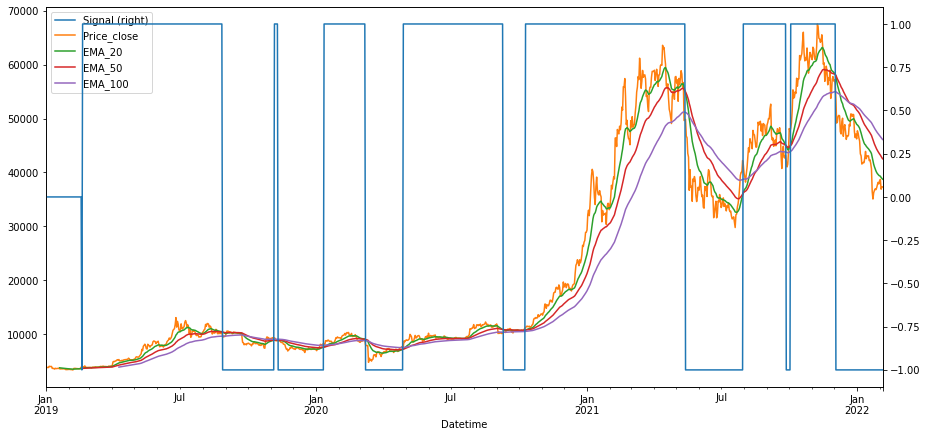

In [200]:
#Combined datafrme
backtesting_combined_df = bt.merge(signal, btc_merged_daily['Close'], EMA_20, EMA_50, EMA_100)

#Plot the signal, price and MA
#combined_df = bt.merge(signal, price_data, EMA_short, EMA_long)
backtesting_combined_df.columns = ['Signal', 'Price_close', 'EMA_20', 'EMA_50', 'EMA_100']
backtesting_combined_df.plot(secondary_y = ['Signal'], figsize=(15, 7))

In [202]:
backtesting_combined_df.fillna(value = 0, inplace = True)
backtesting_combined_df

,Signal,Price_close,EMA_20,EMA_50,EMA_100
Datetime,,,,,
2019-01-01,0.0,3843.520020,0.000000,0.000000,0.000000
2019-01-02,0.0,3943.409424,0.000000,0.000000,0.000000
2019-01-03,0.0,3836.741211,0.000000,0.000000,0.000000
2019-01-04,0.0,3857.717529,0.000000,0.000000,0.000000
2019-01-05,0.0,3845.194580,0.000000,0.000000,0.000000
...,...,...,...,...,...
2022-01-31,-1.0,38466.900000,39368.685577,43410.166975,46829.192512
2022-02-01,-1.0,38694.590000,39304.485998,43225.242387,46668.111275
2022-02-02,-1.0,36896.360000,39075.140665,42977.050921,46474.611249


In [203]:
#Define Strategy
ma_cross = bt.Strategy('EMA_crossover',
                         [bt.algos.WeighTarget(signal),
                         bt.algos.Rebalance()])

In [204]:
#Create the Backtest and run it
bt_backtest = bt.Backtest(ma_cross, price_data)
bt_result = bt.run(bt_backtest)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide



<AxesSubplot:title={'center':'Equity Progression'}>

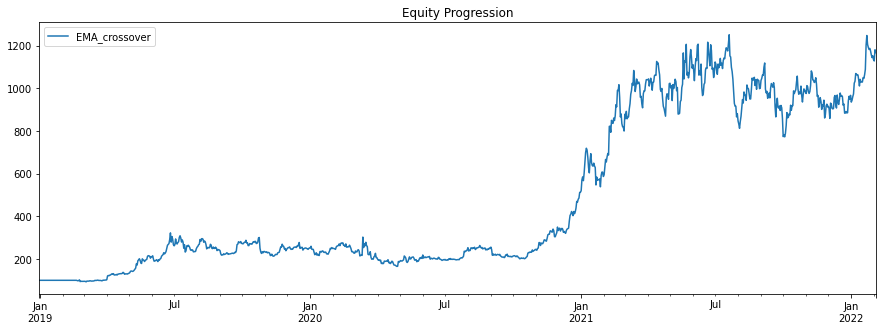

In [205]:
bt_result.plot()

In [206]:
bt_result.display()

Stat                 EMA_crossover
-------------------  ---------------
Start                2018-12-31
End                  2022-02-04
Risk-free rate       0.00%

Total Return         1067.06%
Daily Sharpe         1.19
Daily Sortino        2.10
CAGR                 121.11%
Max Drawdown         -48.74%
Calmar Ratio         2.48

MTD                  2.81%
3m                   18.64%
6m                   38.17%
YTD                  20.67%
1Y                   78.25%
3Y (ann.)            126.79%
5Y (ann.)            121.11%
10Y (ann.)           -
Since Incep. (ann.)  121.11%

Daily Sharpe         1.19
Daily Sortino        2.10
Daily Mean (ann.)    73.35%
Daily Vol (ann.)     61.47%
Daily Skew           0.92
Daily Kurt           11.69
Best Day             39.63%
Worst Day            -16.77%

Monthly Sharpe       1.53
Monthly Sortino      5.37
Monthly Mean (ann.)  97.10%
Monthly Vol (ann.)   63.63%
Monthly Skew         0.96
Monthly Kurt         0.61
Best Month           59.76%
Worst Month 

In [ ]:
#Result 1

#Signal:
#signal[EMA_20> EMA_100] = 1
#signal[EMA_20 <= EMA_100] = -1

#total return = 42% (This is very low)

## 3. Using the Tree Structure (Sub strategies)

In [124]:
#test a strategy that allocated capital to sub-strategies

def ma_cross(ticker: str, short_ma=20, long_ma=50, name='ma_cross'):
    # these are all the same steps as above
    data = read_from_exchange_n(ticker, timeframe='1d')
    data = data.loc[:, ['Close']].copy()
    data.columns = [ticker]
    
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights, i.e strategy
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

#if __name__ == "__main__":
#    ma_cross('BTC')

In [125]:
# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('BTC', name='BTC_ma_cross')
t2 = ma_cross('ETH', name='ETH_ma_cross')

# let's run these strategies now
res = bt.run(t1, t2)

# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['BTC_ma_cross'].prices, res['ETH_ma_cross'].prices)

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res_merged = bt.run(t)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning:

divide by zero encountered in true_divide



<AxesSubplot:title={'center':'Equity Progression'}>

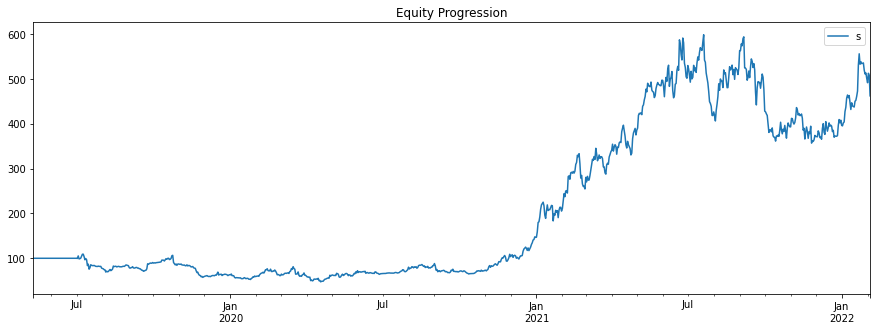

In [128]:
res_merged.plot()

In [127]:
res.display()

Stat                 BTC_ma_cross    ETH_ma_cross
-------------------  --------------  --------------
Start                2019-05-11      2019-05-11
End                  2022-02-04      2022-02-04
Risk-free rate       0.00%           0.00%

Total Return         118.94%         345.13%
Daily Sharpe         0.62            0.89
Daily Sortino        1.08            1.42
CAGR                 33.14%          72.53%
Max Drawdown         -64.77%         -74.54%
Calmar Ratio         0.51            0.97

MTD                  -5.98%          -10.15%
3m                   12.93%          14.59%
6m                   3.03%           7.63%
YTD                  10.47%          16.27%
1Y                   67.91%          63.31%
3Y (ann.)            33.14%          72.53%
5Y (ann.)            -               -
10Y (ann.)           -               -
Since Incep. (ann.)  33.14%          72.53%

Daily Sharpe         0.62            0.89
Daily Sortino        1.08            1.42
Daily Mean (ann.)    38.28

In [129]:
res_merged.display()

Stat                 s
-------------------  ----------
Start                2019-05-10
End                  2022-02-04
Risk-free rate       0.00%

Total Return         361.88%
Daily Sharpe         0.97
Daily Sortino        1.58
CAGR                 74.77%
Max Drawdown         -56.48%
Calmar Ratio         1.32

MTD                  -7.81%
3m                   14.62%
6m                   7.47%
YTD                  13.29%
1Y                   94.72%
3Y (ann.)            74.77%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  74.77%

Daily Sharpe         0.97
Daily Sortino        1.58
Daily Mean (ann.)    54.46%
Daily Vol (ann.)     56.25%
Daily Skew           -0.22
Daily Kurt           2.76
Best Day             15.06%
Worst Day            -15.58%

Monthly Sharpe       1.17
Monthly Sortino      2.76
Monthly Mean (ann.)  76.24%
Monthly Vol (ann.)   65.05%
Monthly Skew         0.31
Monthly Kurt         -0.10
Best Month           49.29%
Worst Month          -32.63%

Yearly S

## Tree Structrure Example: Aapl and msft

In [35]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, start='2010-01-01',
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [bt.algos.WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's run these strategies now
res_stocks = bt.run(t1, t2)

# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res_stocks['aapl_ma_cross'].prices, res_stocks['msft_ma_cross'].prices)

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res_stocks_merged = bt.run(t)

<AxesSubplot:title={'center':'Equity Progression'}>

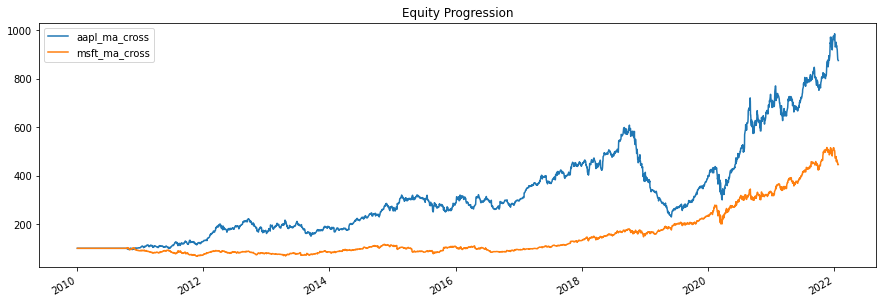

In [36]:
res_stocks.plot()

<AxesSubplot:title={'center':'Equity Progression'}>

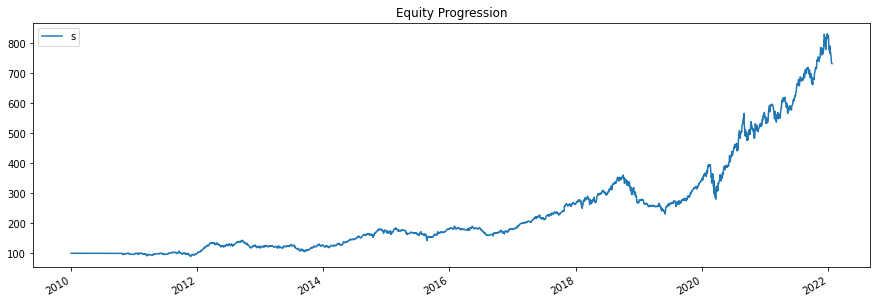

In [37]:
res_stocks_merged.plot()

In [38]:
res_stocks_merged.display()

Stat                 s
-------------------  ----------
Start                2010-01-02
End                  2022-01-24
Risk-free rate       0.00%

Total Return         632.42%
Daily Sharpe         0.89
Daily Sortino        1.43
CAGR                 17.95%
Max Drawdown         -36.10%
Calmar Ratio         0.50

MTD                  -10.49%
3m                   2.30%
6m                   6.49%
YTD                  -10.49%
1Y                   27.20%
3Y (ann.)            37.73%
5Y (ann.)            31.76%
10Y (ann.)           21.29%
Since Incep. (ann.)  17.95%

Daily Sharpe         0.89
Daily Sortino        1.43
Daily Mean (ann.)    18.73%
Daily Vol (ann.)     20.97%
Daily Skew           -0.17
Daily Kurt           12.44
Best Day             13.14%
Worst Day            -13.81%

Monthly Sharpe       0.96
Monthly Sortino      1.92
Monthly Mean (ann.)  18.56%
Monthly Vol (ann.)   19.41%
Monthly Skew         -0.04
Monthly Kurt         0.08
Best Month           15.66%
Worst Month          -13.8